<a href="https://colab.research.google.com/github/alistairwgillespie/UNSW-NB15-Data-Products/blob/master/eda_hosts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Long-tail Analysis of Host Features

# Setup

In [0]:
# Libraries
import pandas as pd
import numpy as np

# from scipy.stats import norm  
# from sklearn.preprocessing import StandardScaler
# from scipy import stats
# from scipy.stats import skew
# from scipy.stats.stats import pearsonr

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

pd.options.display.max_rows = 1000
pd.options.display.max_columns = 20

# Data Ingestion

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
# Link to features table
features_link = 'https://drive.google.com/open?id=1BXqGehJktz4byjo_yxG0xL9GIHOU0qUZ'

# Read in features table data
fluff, id = features_link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('sample_data.csv')  
features_df = pd.read_csv('sample_data.csv', encoding='iso-8859-1')

features_df.head()

,No.,Name,Type,Description
0,1,srcip,nominal,Source IP address
1,2,sport,integer,Source port number
2,3,dstip,nominal,Destination IP address
3,4,dsport,integer,Destination port number
4,5,proto,nominal,Transaction protocol


In [4]:
# Link to sample data
link = 'https://drive.google.com/open?id=1wgmX5978mx3-Vh6aN-Z6ML5LPNY0LOjv'

# Read in sample data
fluff, id = link.split('=')
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile('sample_data.csv')  
df = pd.read_csv('sample_data.csv', header=None)

df.head()

,0,1,2,3,4,5,6,7,8,9,...,39,40,41,42,43,44,45,46,47,48
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


# Data Preprocessing

## Assign column names

In [5]:
# Assigned column headers using the features dataframe
df.columns = features_df['Name'].T
df.reset_index(drop=True, inplace=True)
df.head()

Name,srcip,sport,dstip,dsport,proto,state,dur,sbytes,dbytes,sttl,...,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,attack_cat,Label
0,59.166.0.0,1390,149.171.126.6,53,udp,CON,0.001055,132,164,31,...,0,3,7,1,3,1,1,1,NaN,0
1,59.166.0.0,33661,149.171.126.9,1024,udp,CON,0.036133,528,304,31,...,0,2,4,2,3,1,1,2,NaN,0
2,59.166.0.6,1464,149.171.126.7,53,udp,CON,0.001119,146,178,31,...,0,12,8,1,2,2,1,1,NaN,0
3,59.166.0.5,3593,149.171.126.5,53,udp,CON,0.001209,132,164,31,...,0,6,9,1,1,1,1,1,NaN,0
4,59.166.0.3,49664,149.171.126.0,53,udp,CON,0.001169,146,178,31,...,0,7,9,1,1,1,1,1,NaN,0


## Quantitative vs. Qualitative 



In [6]:
# Distinguish quantitative vs. qualitative features
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

# Label Num variables
quantitative_df = pd.DataFrame(columns = ['variable'], data = quantitative)
quantitative_df['type'] = 'quantitative'

# Label Cat variables
qualitative_df = pd.DataFrame(columns = ['variable'], data = qualitative)
qualitative_df['type'] = 'qualitative'

print("quantitative variables: " + str(quantitative_df.shape[0]))
print("qualitative variables: " + str(qualitative_df.shape[0]))

quantitative variables: 41
qualitative variables: 8


# Explorative Data Analysis

In [7]:
# Describe the data
df.describe()

Name,dur,sbytes,dbytes,sttl,dttl,sloss,dloss,Sload,Dload,Spkts,...,is_ftp_login,ct_ftp_cmd,ct_srv_src,ct_srv_dst,ct_dst_ltm,ct_src_ ltm,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,Label
count,700001.000000,7.000010e+05,7.000010e+05,700001.000000,700001.000000,700001.000000,700001.000000,7.000010e+05,7.000010e+05,700001.000000,...,700001.000000,700001.000000,700001.000000,700001.000000,700001.000000,700001.000000,700001.000000,700001.000000,700001.000000,700001.000000
mean,0.863391,5.009637e+03,4.833038e+04,38.513848,31.980783,6.330444,21.326271,6.024271e+06,3.011023e+06,41.746643,...,0.019623,0.031116,6.380239,6.034169,4.153233,4.668593,1.685498,1.401911,2.188105,0.031736
std,25.935765,4.489868e+04,1.860516e+05,39.996956,30.450757,18.855979,64.733376,5.181492e+07,4.499952e+06,80.198729,...,0.138700,0.278212,5.075147,4.635608,3.740439,4.189667,1.871052,1.426013,2.211199,0.175296
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,0.003931,4.240000e+02,3.040000e+02,31.000000,29.000000,0.000000,0.000000,7.885915e+04,7.640437e+04,4.000000,...,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,0.000000
50%,0.027594,2.024000e+03,3.380000e+03,31.000000,29.000000,4.000000,5.000000,5.362718e+05,6.686759e+05,16.000000,...,0.000000,0.000000,5.000000,5.000000,3.000000,4.000000,1.000000,1.000000,1.000000,0.000000
75%,0.346518,3.806000e+03,2.243200e+04,31.000000,29.000000,7.000000,16.000000,1.078489e+06,3.856223e+06,52.000000,...,0.000000,0.000000,9.000000,8.000000,5.000000,6.000000,2.000000,1.000000,3.000000,0.000000
max,8786.637695,1.367739e+07,1.465542e+07,255.000000,254.000000,5096.000000,5483.000000,5.268000e+09,1.287619e+08,10200.000000,...,1.000000,8.000000,44.000000,42.000000,42.000000,50.000000,36.000000,34.000000,38.000000,1.000000


## Long tail analysis - Hosts

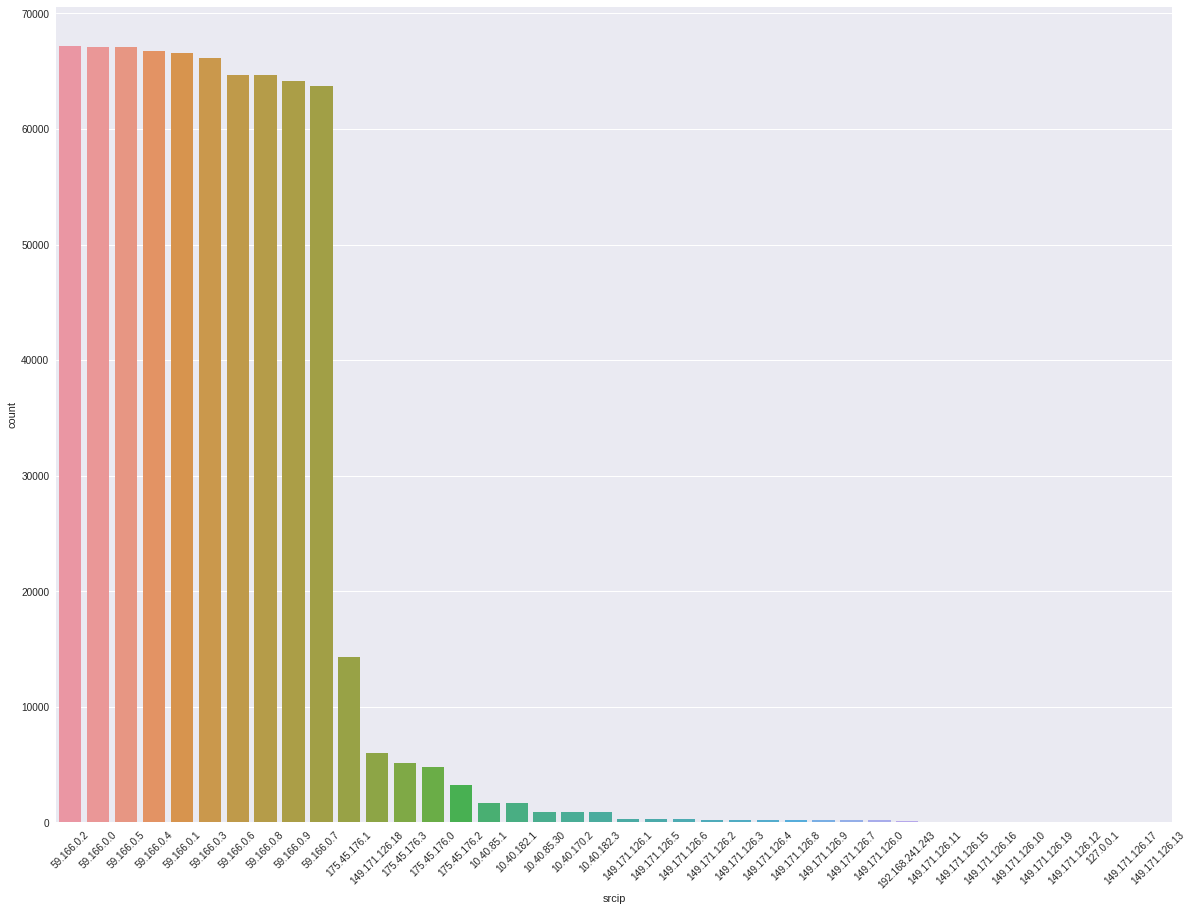

In [8]:
# Plot distribution per srcip
plt.figure(figsize=(20,15))
ax = sns.countplot(x="srcip", data=df, order = df['srcip'].value_counts().index)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [9]:
# Tail of SRC IP
df['srcip'].value_counts().tail()

149.171.126.19    3
149.171.126.12    2
127.0.0.1         1
149.171.126.17    1
149.171.126.13    1
Name: srcip, dtype: int64

In [0]:
# Plot distribution per source port
plt.figure(figsize=(20,15))
ax = sns.countplot(x="sport", data=df, order = df['sport'].value_counts().index)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [0]:
# Tail of source port
df['sport'].value_counts().tail()

In [0]:
# Plot distribution per dstip
plt.figure(figsize=(20,15))
ax = sns.countplot(x="dstip", data=df, order = df['dstip'].value_counts().index)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [0]:
# Tail of destination IP
df['dstip'].value_counts().tail()

In [0]:
# Plot distribution per dest port
plt.figure(figsize=(20,15))
ax = sns.countplot(x="dsport", data=df, order = df['dsport'].value_counts().index)
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

In [0]:
# Tail of dest port
df['dsport'].value_counts().tail()